# Galaxy Morphology EDA & Classification 
## By: Lauren Fisher and Logan Bayer
 
## The data for our classifications and EDA were acquired from the Sloan Digital Sky Server using SQL Queries 

### The URL for the database where the dataset was acquired can be found [here](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zooSpec+U).

## Attribute Values 
The following provides the a list of the attributes and their significance 
* specObjID (int): Spectrum object ID (unique identifier)
* plate (int): Plate number
* mjd (int): MJD of observation
* fiberID (int): Fiber ID
* class (str): Type of object
* p_el (float): Fraction of votes for elliptical galaxy
* p_cw (float): Fraction of votes for clockwise spiral galaxy
* p_acw (float): Fraction of votes for anticlockwise spiral galaxy
* p_edge (float): Fraction of votes for edge-on disk
* p_dk (float): Fraction of votes for don't know
* p_mg (float): Fraction of votes for merger
* ra (deg): Right ascension
* dec (deg): Declination
* z (float): Redshift of object 
* zWarning (int): Warnings for potential errors 
    * 0 - OK: no warnings 
    * 1 - SKY: sky fiber
    * 2 - LITTLE_COVERAGE: too little wavelength coverage (WCOVERAGE < 0.18)
    * 4 - SMALL_DELTA_CHI2: chi-squared of best fit is too close to that of second best (< 0.01 in reduced chi-sqaured)
    * 8 - NEGATIVE_MODEL: synthetic spectrum is negative (only set for stars and QSOs)
    * 16 - MANY_OUTLIERS: fraction of points more than 5 sigma away from best model is too large (> 0.05)
    * 32 - Z_FITLIMIT: chi-squared minimum at edge of the redshift fitting range (Z_ERR set to -1)
    * 64 - NEGATIVE_EMISSION: a QSO line exhibits negative emission, triggered only in QSO spectra, if C_IV, C_III, Mg_II, H_beta, or H_alpha has LINEAREA + 3 * LINEAREA_ERR < 0
    * 128 - UNPLUGGED: the fiber was unplugged, so no spectrum obtained
* waveMin (float): Minimum observed wavelength in angstroms 
* plateSN2 (float): Overall signal-to-noise-squared measure for plate (only set for SDSS spectrograph) 
* h_delta_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4101.7$
* h_gamma_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4340.5$
* oiii_4363_flux (float):  Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 4363$
* h_beta_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4861.4$
* oiii_4959_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 4959$
* oiii_5007_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 5007$
* hei_5876_flux (float): Flux from Gaussian fit to continuum subtracted data for $He^{+}$ at $\lambda = 5876$
* oi_6300_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+}$ at $\lambda = 6300$
* h_alpha_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 6563$
* nii_6548_flux (float): Flux from Gaussian fit to continuum subtracted data for $N^{++}$ at $\lambda = 6584$
* sii_6717_flux (float): Flux from Gaussian fit to continuum subtracted data for $S^{++}$ at $\lambda = 6717$
* sii_6731_flux (float): Flux from Gaussian fit to continuum subtracted data for $S^{++}$ at $\lambda = 6731$

In [48]:
from utils.mypytable import MyPyTable 
import utils.plot_utils as plot_utils
import importlib
import utils.myclassifiers
importlib.reload(utils.myclassifiers)
from utils.myclassifiers import MyDecisionTreeClassifier
from utils.myclassifiers import MyKNeighborsClassifier
from utils.myclassifiers import MyDummyClassifier
from utils.myclassifiers import MyNaiveBayesClassifier
import random

import utils.myevaluation
importlib.reload(utils.myevaluation)
import utils.myevaluation as myevaluation
from itertools import chain
import utils.myutils as utils
importlib.reload(utils)
importlib.reload(plot_utils)
table = MyPyTable()
file_name = 'Skyserver_SQL4_21_2022 12_41_18 AM.csv'
table.load_from_file('input_folder/' + file_name)

# Removing all the unphysical fluxes
def row_idx_flux(table, col_idxs):
    row_indexes = []
    
    for i in range(len(col_idxs)):
        for j in range(len(table)):
            if j not in row_indexes:
                if (table[j][col_idxs[i]] > (1*10**5)) or (table[j][col_idxs[i]] < 0):
                    row_indexes.append(j)

    return row_indexes

col_idxs = list(range(17, 28 + 1)) # Plus 1 to account for exclusivity (17 start of fluxes)

row_flux =  row_idx_flux(table.data, col_idxs) # Identifies 18 rows with unphysical fluxes
b_len = len(table.data)
table.drop_rows(row_flux)
a_len =len(table.data)
print("Removed instances:", b_len - a_len)

# Data Cleaning 
# Removing all zWarning that are not (0 - OK)
values, counts = utils.get_frequencies(table.data, 14)
print("zwarning values:", values)
print("zWarning counts:", counts) # Removing only 36 instances

def row_indexes_to_drop(table, col_idx):
    row_indexes = []
    row_indexes = [i for i in range(len(table)) if table[i][col_idx] != 0]

    return row_indexes

row_idxs = row_indexes_to_drop(table.data, 14)
print(row_idxs, len(row_idxs))
b_len = len(table.data)
table.drop_rows(row_idxs)
a_len = len(table.data)
print("Removed instances:", b_len - a_len)
# Takes 34s to remove 36 instances

for i in range(len(col_idxs)):
    for j in range(len(table.data)):
        table.data[j][col_idxs[i]] = table.data[j][col_idxs[i]] / table.data[j][col_idxs[3]] # 3 indicates index of h_beta_flux in col_idxs

summary_table = table.compute_summary_statistics(['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'ra', 'dec', 'z', 'zWarning', 'waveMin', 'plateSN2', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux'])
summary_table.pretty_print()

Removed instances: 14997
zwarning values: [0.0, 4.0, 16.0, 64.0]
zWarning counts: [4987, 1, 13, 2]
[401, 695, 911, 1240, 1771, 2600, 2791, 2902, 3175, 3322, 3412, 3634, 4181, 4204, 4414, 4935] 16
Removed instances: 16
attribute                 min           max          mid           avg        median
--------------  -------------  ------------  -----------  ------------  ------------
p_el               0               1            0.5          0.403618      0.422
p_cw               0               1            0.5          0.109711      0.029
p_acw              0               1            0.5          0.114025      0.033
p_edge             0               1            0.5          0.259218      0.2
p_dk               0               0.857        0.4285       0.080292      0.058
p_mg               0               0.926        0.463        0.0330559     0
ra                 0.0421753     359.853      179.947      200.028       187.864
dec               -3.74089        66.1556      31.2

In [49]:
fraction_cols = ['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg']
utils.discretize_to_single_col(table.data, table.column_names, fraction_cols)
table.column_names.append('morph')
print(len(table.data[0]))
table.drop_cols(fraction_cols)
print(len(table.data[0]))

30
24


## Class Distribution

#### We are hoping to train our model on the class label for morphology classification which is a system used by astronomers to divide galaxies into groups based on their visual appearance.

#### In order to ensure that we can fit a good model to the data, having a distribution of class labels that are not too skewed so as to be overly abundant or lacking in some versus others 

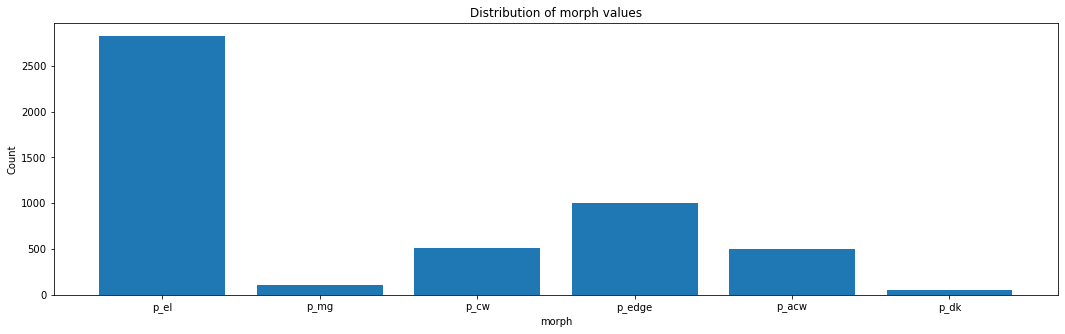

In [50]:
col = 'morph'
vals,counts = utils.get_categorical_frequencies(table.data, table.column_names, col)
plot_utils.categorical_frequency_bar_plot(col, vals, counts)


2825
2162


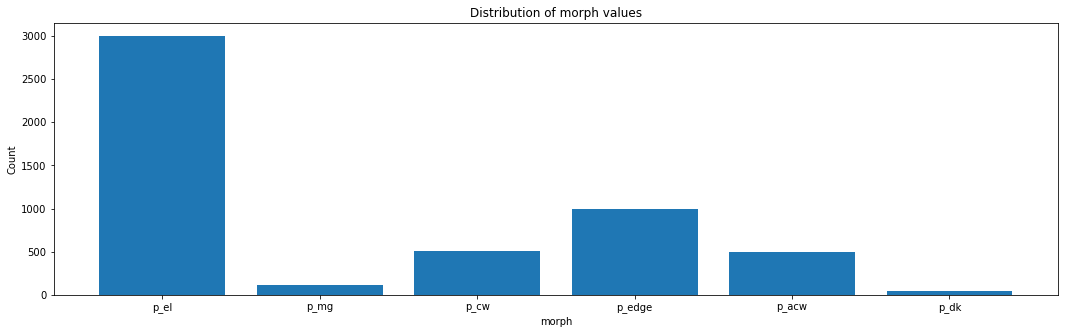

In [51]:
z_warning_col =  table.column_names.index('zWarning')
row_indexes = [i for i in range(len(table.data)) if table.data[i][z_warning_col] != 0]

morph_col = table.column_names.index('morph')
el_table = []
other_table = []
for i in range(len(table.data)):
    if table.data[i][morph_col] == 'p_el':
        el_table.append(table.data[i])
    else:
        other_table.append(table.data[i])

print(len(el_table))
print(len(other_table))
rand_sub = []
num_els = 3000
sub_els = []
random.seed(0)
for _ in range(num_els):
    rand_idx = random.randint(0, len(el_table) - 1)
    if rand_idx not in rand_sub:
        sub_els.append(el_table[rand_idx])

table.data = sub_els + other_table



vals,counts = utils.get_categorical_frequencies(table.data, table.column_names, col)
plot_utils.categorical_frequency_bar_plot(col, vals, counts)


#### From our initial EDA we see that our class distribution is unbalanced in favor of votes for p_el which signifies an eliptical galaxy with very few classifications in favor of p_dk which is for don't know... which I guess is good?

## A Closer Look: Features of Interest

#### Like the distributions of class lables we also used the opportunity for EDA to look into whether or not there were any features within the dataset that have high or low correlations with other attributes/class labels so as to gain intuition for potential pruning strategies or attributes to eliminate to reduce overfitting

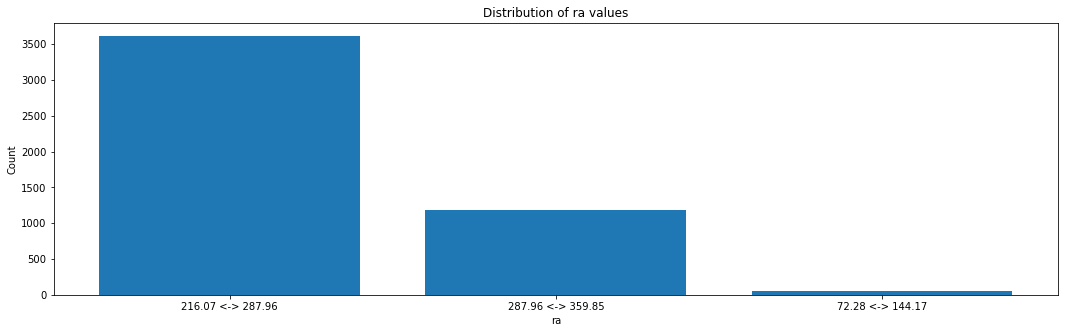

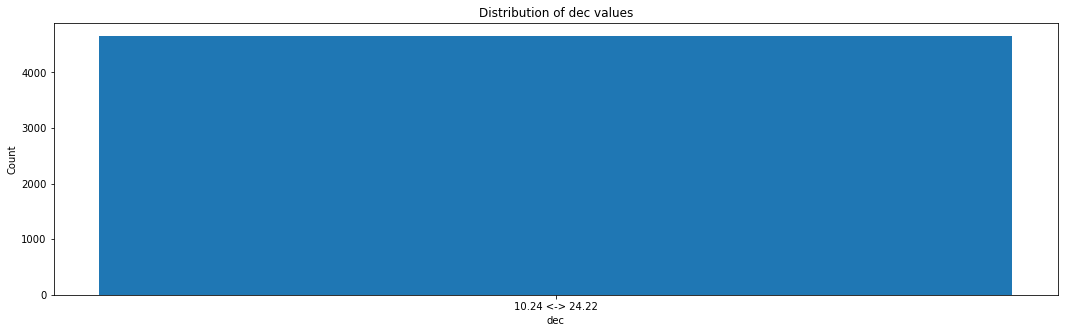

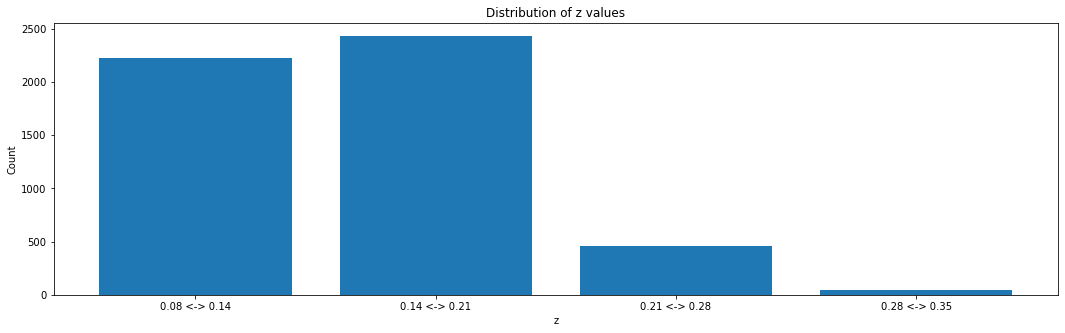

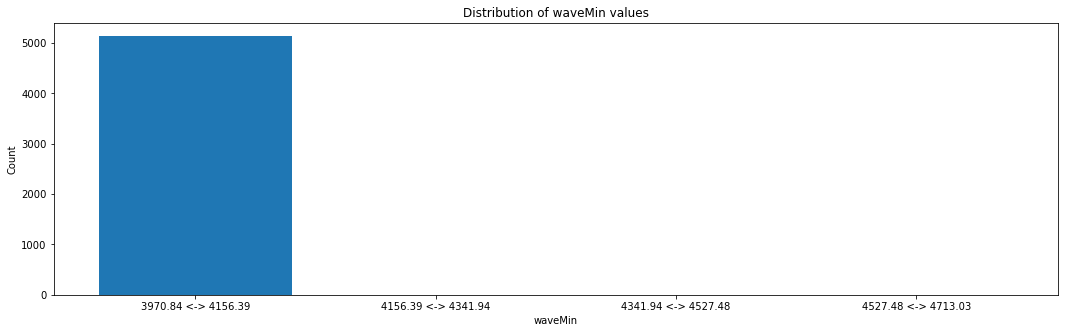

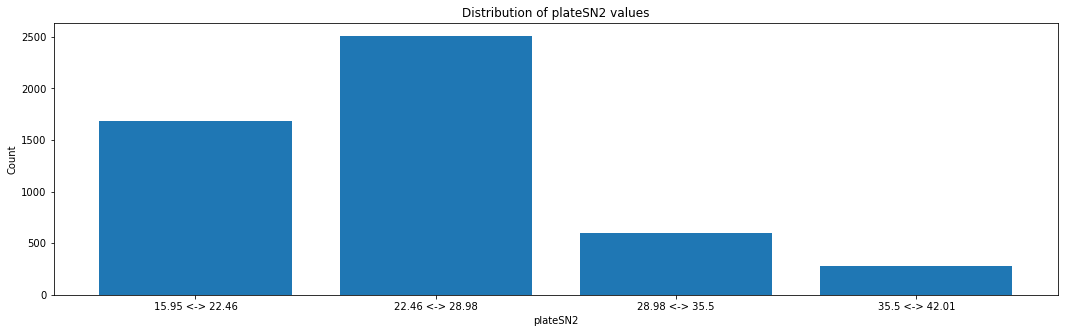

In [52]:
fluxs = ['h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux']
flux_col_idxs = [table.column_names.index(flux) for flux in fluxs]
table.data = [[int(row[i]) if i in flux_col_idxs else row[i] for i in range(len(row))] for row in table.data]


rows_to_drop = []
for i in range(len(table.data)):
    for j in range(len(table.data[i])):
        if j in flux_col_idxs:
            if table.data[i][j] < -1*10**5 or table.data[i][j] > 1*10**5:
                rows_to_drop.append(i)
            
table.drop_rows(rows_to_drop)



cols = ['ra', 'dec', 'z', 'waveMin', 'plateSN2'] 
importlib.reload(utils)
importlib.reload(plot_utils)
for column in cols:
    col = table.get_column(column, False)
    edges = utils.compute_equal_width_cutoffs(col, 5)
    labels = [str(edges[i]) +' <-> ' +str(edges[i+1]) for i in range(5)]
    range_array = utils.range_discretization(edges, labels, table.data, table.column_names, column)
    ranges,cts = utils.get_array_frequencies(range_array)
    plot_utils.categorical_frequency_bar_plot(column, ranges, cts)

###

## Distribution of Fluxes Measured From Spectroscopy Graphs

[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [0.38857464, 359.85275], [-3.7408931, 66.155617], [1, 1], [1, 1], [3785.297, 4713.028], [9.43218, 42.013], [0, 44], [0, 19], [0, 4], [1, 1], [0, 3139], [0, 9966], [0, 1772], [0, 795], [0, 16212], [0, 1224], [0, 1323], [0, 1779], [1, 1]]
['specObjID', 'plate', 'mjd', 'fiberID', 'class', 'ra', 'dec', 'z', 'zWarning', 'waveMin', 'plateSN2', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux', 'morph']
[6, 5, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]
24


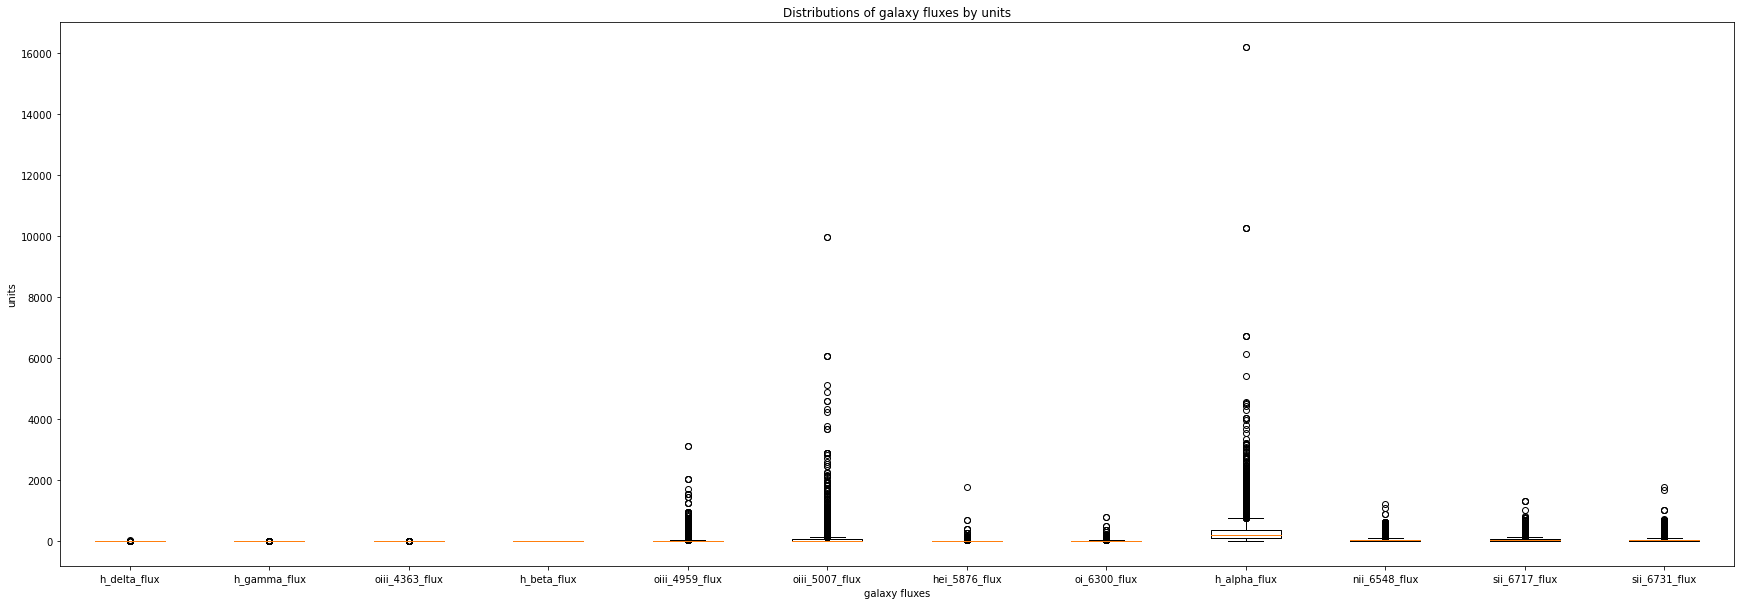

In [53]:
scaled_cols = ['dec', 'ra', 'waveMin', 'plateSN2','h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux']
scaled_col_idxs = [table.column_names.index(col) for col in scaled_cols] # , 'h_beta_flux' removed from scaled cols as it will divide by zero
dists = []
for flux_col_idx in flux_col_idxs:
    table.data = [row for row in table.data if row[flux_col_idx] < 5*10**6]
col_vals = []
for flux in fluxs:
    col = table.get_column(flux)
    dists.append(col)

for i in range(len(table.data[0])):
    if i in scaled_col_idxs:
        col = table.get_column(table.column_names[i])
        col_vals.append([min(col), max(col)])
    else:
        col_vals.append([1,1])

print(col_vals)
print(table.column_names)
print(scaled_col_idxs)

print(len(table.data[0]))

for i in range(len(table.data)):
    for j in range(len(table.data[i])):
        if j in scaled_col_idxs:
            table.data[i][j] = (table.data[i][j] - col_vals[j][0]) / (col_vals[j][1] - col_vals[j][0])

plot_utils.box_plot_example(dists, fluxs, ['galaxy fluxes', 'units'])

#### We might want to further filter down the rows which have outliers for these fluxes as they could be hard for our model to generalize

### Preliminary Classification

In [54]:

cols_to_remove = ['specObjID', 'plate', 'mjd', 'fiberID', 'zWarning', 'class', 'morph'] 
target_vals = table.get_column('morph')
table.drop_cols(cols_to_remove)

In [58]:
import copy 

utils.randomize_in_place(table.data, target_vals)
table_copy = copy.deepcopy(table.data)
table_copy = table_copy[0:2000]
X_train_idx_folds, X_test_idx_folds = myevaluation.stratified_kfold_cross_validation(
    table_copy, target_vals, n_splits=7)

X_train = [[table_copy[idx] for idx in fold] for fold in X_train_idx_folds]
y_train = [[target_vals[idx] for idx in fold]
            for fold in X_train_idx_folds]
X_test = [[table_copy[idx] for idx in fold] for fold in X_test_idx_folds]
y_test = [[target_vals[idx] for idx in fold]
            for fold in X_test_idx_folds]

knn = MyKNeighborsClassifier(5)
dummy = MyDummyClassifier()
bayes = MyNaiveBayesClassifier()
# dec_tree = MyDecisionTreeClassifier()

classifier_names = ['dummy', 'knn']
models = [dummy, knn]
preds = [[] for _ in models]

for i in range(len(X_train)):
    for j in range(len(models)):
        models[j].fit(X_train[i], y_train[i])
        preds[j] += models[j].predict(X_test[i])

y_test = list(chain.from_iterable(y_test))

for i in range(len(preds)):
    myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])

print(target_vals[0:1000])

KeyboardInterrupt: 

## Next Steps

* Further Cleaning of Flux's
* Determine a more optimal way to downsample our original 20,000 instance dataset
* Possibly reduce number of features via Sklearn alg.
* Further discretization of features? continuous -> discrete

## TO DO 
1. Any zWarning not 0, remove 
1. Use waveMin and waveMax as cuts (waveMin > H_delta_4101 cut, waveMax < sii_6731)
1. Cut unphysical fluxes (check fluxes from summer/spot check high flux galaxies)
1. Normalize fluxes with H_beta
1. Manage class imbalance with resampling 
1. Precision and recall multi-class tweaks
1. Min-max scaling for kNN
1. Times for redshifts (cosmological constant)
1. Have fun!
